In [1]:
%cd -q /home/dataproc
!ls inverted_index_gcp.py
from inverted_index_gcp import *

inverted_index_gcp.py


In [2]:
!pip install gensim
!pip install nltk==3.7

In [ ]:
# !pip uninstall nltk
# !pip install -U nltk

In [20]:
from time import time as tm
from metrics import *
from bucket_manipulation import *
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from nltk.util import ngrams
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

In [5]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import numpy as np
from itertools import combinations
import math
from itertools import chain
import time

In [13]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"amazing-badge-343010-879c0a90f001.json"

### Download Indecies Files from Buckets

In [14]:
TEXT_BUCKET = 'body_text_no_stem'
TEXT_STEM_BUCKET = 'body_stem'
TITLE_BUCKET = 'tile_no_stem'
ANCHOR_BUCKET = 'anchor_bucket3'
ANCHOR_DOUBLE_BUCKET = 'double_anchor_index'
EXTRA_FILES_BUCKET = 'extra_files_search'


# ---- Initialize Indices ----
text_index = ReadBucketData(TEXT_BUCKET).get_inverted_index(source_idx='postings_gcp/inverted_index_text.pkl',
                                                            dest_file='downloaded/index.pkl')

text_stem_index = ReadBucketData(TEXT_STEM_BUCKET).get_inverted_index(source_idx='postings_gcp/index_body_bucket0.pkl',
                                                            dest_file='downloaded/index.pkl')

title_index = ReadBucketData(TITLE_BUCKET).get_inverted_index(source_idx='postings_gcp/title_index_nostem.pkl',
                                                              dest_file='downloaded/index.pkl')

anchor_index = ReadBucketData(ANCHOR_BUCKET).get_inverted_index(source_idx='postings_gcp/index_anchor_bucket0.pkl',
                                                              dest_file='downloaded/index.pkl')

anchor_double_index = ReadBucketData(ANCHOR_DOUBLE_BUCKET).get_inverted_index(source_idx='postings_gcp/inverted_index_anchor_double.pkl',
                                                              dest_file='downloaded/index.pkl')


anchor_double_index.df = dict(anchor_double_index.df)

# ---- Initialize Page Rank, Views, id2title and word2vec model ----
page_views = ReadBucketData(EXTRA_FILES_BUCKET).get_pkl_file("pages/pageviews.pkl", "downloaded/pageviews.pkl")
page_rank = pd.read_pickle(ReadBucketData(EXTRA_FILES_BUCKET).download_from_buck("pages/page_rank.pickle", "downloaded/page_rank.pickle"))

# ---- calculate and Save Amount of docs, Doc Length for eah doc and id2title mapping dict ----
id2title = pd.read_pickle(ReadBucketData(EXTRA_FILES_BUCKET).download_from_buck("pages/id2title.pickle", "downloaded/id2title.pickle"))
num_of_docs = len(text_index.DL)
DL = text_index.DL
DL_normed = text_index.DS

### Download Word2Vec over Wikipedia model from Bucket

In [16]:
# ---- download word2vec over wikipedia model  -----
word2vec_file = ReadBucketData(EXTRA_FILES_BUCKET).download_from_buck("wiki-news-300d-1M.vec", "downloaded/wiki-news-300d-1M.vec")
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file)

### Function for calculating TFIDF and Cosine Similarity

In [22]:
# -------- tfidf retrievel functions --------

def calc_idf(index, token):
    """Calculate the IDF of a token in an index."""
    return np.log2(len(index.DL) / (index.df[token]))


def calc_tfidf(tf: float, idf: float, dl: float) -> float:
    """Calculate the TF-IDF of a token in a document."""
    return tf * idf / dl


def update_query_tfidf(idf: float, tokens: list, token: str, QL: float) -> float:
    """Update the TF-IDF score of a token in the query."""
    tf = tokens.count(token)
    return calc_tfidf(tf, idf, QL)


def get_query_and_docs_tfidf(tokens: list, index: InvertedIndex, QL: float, bucket_name: str) -> tuple:
    """Calculate the TF-IDF scores of tokens in a query and documents."""
    query = {}
    docs = defaultdict(list)
    for token in set(tokens):  # Only calculate the TF-IDF score for each unique token once
        postings = get_posting(index, token, bucket_name)
        idf = calc_idf(index, token)
        query[token] = update_query_tfidf(idf, tokens, token, QL)
        for doc_id, freq in postings:
            docs[token].append((doc_id, calc_tfidf(freq, idf, index.DL[doc_id])))
    return query, docs


def calc_cosine_similarity(query_tfidf: dict, docs_tfidf: dict, QL: float, index: InvertedIndex) -> dict:
    """Calculate the cosine similarity between a query and documents."""
    cosine_sim = {}
    for token, val in docs_tfidf.items():
        for doc_id, tfidf in val:
            if doc_id in cosine_sim:
                cosine_sim[doc_id] += tfidf * query_tfidf[token]
            else:
                cosine_sim[doc_id] = tfidf * query_tfidf[token]
    return {doc_id: numerator / DL_normed[doc_id] * QL for doc_id, numerator in cosine_sim.items()}


def get_docs_id_ordered_by_cosine_similarity(cosine_sim: Dict[int, float]) -> List[int]:
    """Returns sorted document IDs based on cosine similarity."""
    return sorted(cosine_sim, key=cosine_sim.get, reverse=True)

### Functions from core functions Module

In [23]:
# ---------- core functions --------------
def tokenize(text: str, stem=False, bigram=False, expand=False) -> List[str]:
    stemmer = PorterStemmer()
    RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
    corpus_stopwords = ["category", "references", "also", "external", "links",
                        "may", "first", "see", "history", "people", "one", "two",
                        "part", "thumb", "including", "second", "following",
                        "many", "however", "would", "became", 'make']
    stopwords_frozen = frozenset(stopwords.words('english'))
    all_stopwords = stopwords_frozen.union(corpus_stopwords)

    tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if
                      token.group() not in all_stopwords]
    if expand:
        tokens = expand_query_with_synonyms(tokens, word2vec_model)
        tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if
                      token.group() not in all_stopwords]
    if bigram:
        tokens = ngrams(tokens, 2)
    if stem:
        tokens = [stemmer.stem(term) for term in tokens if term not in all_stopwords]
    else:
        tokens = [term for term in tokens if term not in all_stopwords]

    return tokens


def get_posting(index: InvertedIndex, token: str, bucket_name: str):
    posting_list = []
    with closing(MultiFileReader()) as reader:
        locs = [(posting_loc[0], posting_loc[1]) for posting_loc in index.posting_locs[token]]
        b = reader.read(locs, index.df[token] * TUPLE_SIZE, bucket_name)
        for i in range(index.df[token]):
            doc_id = int.from_bytes(b[i * TUPLE_SIZE:i * TUPLE_SIZE + 4], 'big')
            tf = int.from_bytes(b[i * TUPLE_SIZE + 4:(i + 1) * TUPLE_SIZE], 'big')
            posting_list.append((doc_id, tf))
    return posting_list


def binary_search(query: str, index: InvertedIndex, bucket_name: str):
    doc_counts = {}
    for token in set(query):
        token_posting = get_posting(index, token, bucket_name)
        for doc_id, tf in token_posting:
            doc_counts[doc_id] = doc_counts.get(doc_id, 0) + 1
    sorted_doc_counts = Counter(doc_counts)
    return [doc_id for doc_id, _ in sorted_doc_counts.most_common()]


def map_doc_id2title(docs_id: List[int]) -> List[Tuple[int, str]]:
    """ Maps a list of document IDs to their corresponding titles."""
    return [(doc_id, id2title[doc_id]) for doc_id in docs_id]


def map_tuple2doc_id(scores: List[Tuple]) -> List[int]:
    """
    Given a list of tuples, where each tuple contains a document ID and a score,
    returns a list of the document IDs.
    """
    return [t[0] for t in scores]


def expand_query_with_synonyms(query_tokens: List[str], word_embedding_model) -> List[str]:
    """
    Expands a query by replacing each token with its most similar words as per the provided word embedding model.
    :param query_tokens: A list of query tokens (strings) to be expanded.
    :param word_embedding_model: A pre-trained word embedding model such as gensim's Word2Vec.
    :return: A list of expanded query tokens.
    """
    expanded_tokens = []
    for token in query_tokens:
        if token in word_embedding_model:
            synonyms = word_embedding_model.most_similar(token, topn=2)
            for synonym in synonyms:
                expanded_tokens.append(synonym[0])
        expanded_tokens.append(token)
    return expanded_tokens


### BM25 class and functions

In [24]:
class BM25:
    """
    Best Match 25.
    ----------
    k1 : float, default 1.5
    b : float, default 0.75

    index: inverted index
    """

    def __init__(self, index, bucket_name, DL, k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1
        self.index = index
        self.DL = DL
        self.N = len(DL)
        self.AVGDL = sum(DL.values()) / self.N
        self.bucket_name = bucket_name

    def get_candidate_documents_and_scores(self, query):
        candidates = {}
        terms_postings = {}
        for term in np.unique(query):
            list_of_doc = get_posting(self.index, term, self.bucket_name)
            terms_postings[term] = list_of_doc
            normlized_tfidf = [(doc_id, (freq / self.DL[doc_id]) * math.log(len(self.DL) / self.index.df[term], 10)) for
                               doc_id, freq in list_of_doc]

            for doc_id, tfidf in normlized_tfidf:
                candidates[(doc_id, term)] = candidates.get((doc_id, term), 0) + tfidf
        return candidates, terms_postings

    def calc_idf(self, list_of_tokens):
        idf = {}
        for term in list_of_tokens:
            if term in self.index.df.keys():
                n_ti = self.index.df[term]
                idf[term] = math.log(1 + (self.N - n_ti + 0.5) / (n_ti + 0.5))
            else:
                pass
        return idf

    def search(self, query, N=100):
        self.idf = self.calc_idf(query)
        # get relevant canidate docs
        candidate_docs_and_tfidf, terms_postings = self.get_candidate_documents_and_scores(query)
        candidate_docs = [key[0] for key in candidate_docs_and_tfidf.keys()]
        # for each doc add score for query and add to scores dict
        score = [(doc_id, self._score(query, doc_id, terms_postings)) for doc_id in np.unique(candidate_docs)]
        return sorted(score, key=lambda x: x[1], reverse=True)[:N]

    def _score(self, query, doc_id, terms_postings):
        score = 0.0
        doc_len = self.DL[doc_id]

        for term in query:
            if term in self.index.df.keys():
                term_frequencies = dict(terms_postings[term])
                if doc_id in term_frequencies.keys():
                    freq = term_frequencies[doc_id]
                    numerator = self.idf[term] * freq * (self.k1 + 1)
                    denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.AVGDL)
                    score += (numerator / denominator)
        return score


# --------- BM25 functions ---------

def convert_bm25_score_to_title_and_id(scores: List[Tuple[int, float]]) -> List[Tuple[str, int]]:
    """
    Given a list of tuples representing document scores, where each tuple contains
    a document ID and a BM25 score, returns a list of tuples where each tuple
    contains the title of the document and its ID.
    """
    doc_ids = map_tuple2doc_id(scores)
    return map_doc_id2title(doc_ids)


def calc_bm25(query: str, index, bucket_name, DL) -> List[Tuple[str, int]]:
    """
    Given a query string and a index of tokenized documents, returns a list of tuples where each tuple
    contains the title of the document and its ID, sorted by relevance to the query as determined by BM25 ranking.
    """
    bm25_index = BM25(index, bucket_name, DL)
    bm25_score = bm25_index.search(query, 100)
    return bm25_score


### Search Functions with basic and advanced Search Functions

In [25]:
# ------ Search Functions ----------

def calc_search_title(query: str):
    query = tokenize(query)
    docs_id = binary_search(query, title_index, TITLE_BUCKET)
    return docs_id[:100]


def calc_search_anchor(query: str):
    query = tokenize(query)
    docs_id = binary_search(query, anchor_index, ANCHOR_BUCKET)
    return docs_id[:100]


def calc_search_body(query: str):
    query = tokenize(query)
    QL = len(query)
    QL_norm = np.linalg.norm(QL)
    query_tfidf, docs_tfidf = get_query_and_docs_tfidf(query, text_index, QL_norm, TEXT_BUCKET)
    cosine_sim = calc_cosine_similarity(query_tfidf, docs_tfidf, QL_norm, text_index)
    docs_id = get_docs_id_ordered_by_cosine_similarity(cosine_sim)

    return docs_id[:100]


def calc_search_body_stem(query: str):

    query = tokenize(query, stem=True)
    QL = len(query)
    QL_norm = np.linalg.norm(QL)
    query_tfidf, docs_tfidf = get_query_and_docs_tfidf(query, text_stem_index, QL_norm, TEXT_STEM_BUCKET)
    cosine_sim = calc_cosine_similarity(query_tfidf, docs_tfidf, QL_norm, text_stem_index)
    docs_id = get_docs_id_ordered_by_cosine_similarity(cosine_sim)

    return docs_id[:100]


def calc_search_anchor_double(query: str):
    query = tokenize(query)
    docs_id = binary_search(query, anchor_double_index, ANCHOR_DOUBLE_BUCKET)
    return docs_id[:100]


def search_bm25_body(query: str):
    query = tokenize(query)
    return calc_bm25(query, text_index, TEXT_BUCKET, DL)



def search_bm25_body_stem(query: str):
    query = tokenize(query, stem=True)
    return calc_bm25(query, text_stem_index, TEXT_STEM_BUCKET, DL)


# ------- Page Views and Page Rank Functions
def get_page_view(docs_id: List[str]) -> List[int]:
    values = [page_view[doc_id] for doc_id in docs_id]
    return values


def get_page_rank(docs_id: List[str]) -> List[int]:
    values = [page_rank[doc_id] for doc_id in docs_id]
    return values

#### Test that the functions work properly

In [26]:
q = "best marvel movie"
res = calc_search_body(q)
map_doc_id2title(res[:10])

[(39632709, 'Marvel (name)'),
 (5027882, 'Marvel Entertainment'),
 (306960, 'Marvel'),
 (1074657, 'Marvel Studios'),
 (13686413, 'Marvel vs. DC'),
 (5727147, 'Marvel Animation'),
 (403579, 'Captain Marvel'),
 (26552494, 'Paolo Rivera'),
 (66113901, 'Marvel Legends (disambiguation)'),
 (20966, 'Marvel Comics')]

In [27]:
q = "best marvel movie"
res = calc_search_title(q)
map_doc_id2title(res[:10])

[(3395911, "Critics' Choice Movie Award for Best Picture"),
 (3396154, "Critics' Choice Movie Award for Best Actress"),
 (3396197, "Critics' Choice Movie Award for Best Actor"),
 (3397294, "Critics' Choice Movie Award for Best Young Performer"),
 (3398766, "Critics' Choice Movie Award for Best Director"),
 (3398913, "Critics' Choice Movie Award for Best Foreign Language Film"),
 (3399194, "Critics' Choice Movie Award for Best Supporting Actor"),
 (3405654, "Critics' Choice Movie Award for Best Supporting Actress"),
 (3405727, "Critics' Choice Movie Award for Best Acting Ensemble"),
 (3406519, "Critics' Choice Movie Award for Best Song")]

In [28]:
q = "best marvel movie"
res = calc_search_anchor(q)
map_doc_id2title(res[:10])

[(20966, 'Marvel Comics'),
 (302602, 'Wolverine (character)'),
 (18487634, 'List of Marvel Comics characters: K'),
 (62372638, 'Characters of the Marvel Cinematic Universe'),
 (316255, 'Avengers (comics)'),
 (27936, 'Spider-Man'),
 (2268649, 'Transformers (comics)'),
 (22114132, 'The Avengers (2012 film)'),
 (1074657, 'Marvel Studios'),
 (184420, 'Deadpool')]

In [29]:
q = "best marvel movie"
res = calc_search_body_stem(q)
map_doc_id2title(res[:10])

[(306960, 'Marvel'),
 (7997206, 'Marvelous'),
 (5027882, 'Marvel Entertainment'),
 (39632709, 'Marvel (name)'),
 (403579, 'Captain Marvel'),
 (1074657, 'Marvel Studios'),
 (48707839, 'Marvels (disambiguation)'),
 (13686413, 'Marvel vs. DC'),
 (5727147, 'Marvel Animation'),
 (26552494, 'Paolo Rivera')]

In [30]:
q = "אמיר הלוי"
res = calc_search_title(q)
map_doc_id2title(res[:10])

KeyError: 'הלוי'

In [31]:
q = "best marvel movie"
res = calc_search_anchor_double(q)
map_doc_id2title(res[:10])

[(21958604, '2011 United Kingdom census'),
 (61702, 'Academy Award for Best Picture'),
 (61760, 'Academy Award for Best International Feature Film'),
 (23245556, 'Academy Award for Best Actress'),
 (23245410, 'Academy Award for Best Actor'),
 (19599929, 'Republic of the Congo'),
 (61827, 'Academy Award for Best Supporting Actress'),
 (24128375, 'Academy Award for Best Original Song'),
 (23251708, 'Academy Award for Best Supporting Actor'),
 (83065, 'Academy Award for Best Original Score')]

### Experiment and Evaluate Functions

In [32]:
# load train queries
queries = None
with open('queries_train.json', 'rt') as f:
    queries = json.load(f)
queries['Cigarettes'] = queries.pop('Ciggarets')

In [33]:
# The Average precision function given for test Search funcs
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i, doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions) + 1) / (i + 1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions) / len(precisions), 3)

In [34]:
def test_search_funcs_average_precision(func, queries):
    qs_res = []
    for q, true_wids in queries.items():
        duration, ap = None, None
        true_wids = list(map(int, true_wids))
        t_start = tm()
        pred_wids = func(q)
        duration = tm() - t_start
        ap = average_precision(true_wids, pred_wids)
        qs_res.append((q, duration, ap))
    scores = [x[2] for x in qs_res]
    times = [x[1] for x in qs_res]
    mean_score = sum(scores) / len(scores)
    mean_time = sum(times) / len(times)
    print(f"mean score: {mean_score}")
    print(f"mean times: {mean_time}")
    print(f"total time: {sum(times)}")
    print(f'ansewr per each q: {qs_res}')
    return mean_score, mean_time
    
    
def mean_scores(dicts):
    mean_scores_dict = defaultdict(float)
    count_scores_dict = defaultdict(int)
    for d in dicts:
        query, time, scores_dict = d
        for key in scores_dict.keys():
            mean_scores_dict[key] += scores_dict[key][0]
            count_scores_dict[key] += 1
    for key in mean_scores_dict.keys():
        mean_scores_dict[key] /= count_scores_dict[key]
    return mean_scores_dict
    
    
def test_search_funcs_all_metrices(func, queries):
    qs_res = []
    for q, true_wids in queries.items():
        duration, ap = None, None
        true_wids = list(map(int, true_wids))
        t_start = tm()
        pred_wids = func(q)
        duration = tm() - t_start
        scores = evaluate_all_metrics(true_wids, pred_wids, k=40, print_scores=False)
        qs_res.append((q, duration, scores))
    mean_score = mean_scores(qs_res)
    print(f'Average scores over all queries: {mean_score}')
    return qs_res, mean_score

In [35]:
functions = [calc_search_body, calc_search_title, calc_search_anchor, calc_search_body_stem, calc_search_anchor_double]
function_names = ["search_body", "search_title", "search_anchor", "search_body_stem", "search_anchor_double"]
func_results = {}
for func, func_name in zip(functions, function_names):
    print(f"Scores for func {func_name}")
    func_results[func_name]= test_search_funcs_average_precision(func, queries)

Scores for func search_body
mean score: 0.3328999999999999
mean times: 2.3630966663360597
total time: 70.89289999008179
ansewr per each q: [('best marvel movie', 4.64351487159729, 0.5), ('How do kids come to world?', 7.777389287948608, 0.0), ('Information retrieval', 1.8495426177978516, 0.517), ('LinkedIn', 0.12235236167907715, 0.858), ('How to make coffee?', 0.27086758613586426, 0.461), ('Ritalin', 0.13549041748046875, 0.737), ('How to make wine at home?', 3.776982069015503, 0.105), ('Most expensive city in the world', 11.083763837814331, 0.0), ('India', 1.3834729194641113, 0.358), ('how to make money fast?', 1.6731343269348145, 0.107), ('Netflix', 0.1905202865600586, 0.89), ('Apple computer', 1.2118792533874512, 0.588), ('The Simpsons', 0.29579615592956543, 0.199), ('World cup', 7.241116285324097, 0.1), ('How to lose weight?', 0.9160432815551758, 0.084), ('Java', 0.27622103691101074, 0.438), ('Air Jordan', 2.056077718734741, 0.534), ('how to deal with depression?', 1.3657376766204834

In [36]:
scores ={}
for func, func_name in zip(functions, function_names):
    print(f"Scores for func {func_name}")
    scores[func_name] = test_search_funcs_all_metrices(func, queries)

Scores for func search_body
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.14823333333333333, 'precision@k': 0.14583333333333334, 'f_score@k': 0.1397853185276755, 'r-precision': 0.16293333333333335, 'MRR@k': 0.4873260073260072, 'MAP@k': 0.3328999999999999})
Scores for func search_title
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.12206666666666664, 'precision@k': 0.1716666666666667, 'f_score@k': 0.11947641974646749, 'r-precision': 0.18823333333333334, 'MRR@k': 0.5828402445507709, 'MAP@k': 0.4778333333333334})
Scores for func search_anchor
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.08829999999999999, 'precision@k': 0.14250000000000002, 'f_score@k': 0.10105345657366055, 'r-precision': 0.14116666666666663, 'MRR@k': 0.5712830687830687, 'MAP@k': 0.4325666666666666})
Scores for func search_body_stem
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.13929999999999998, 'pr

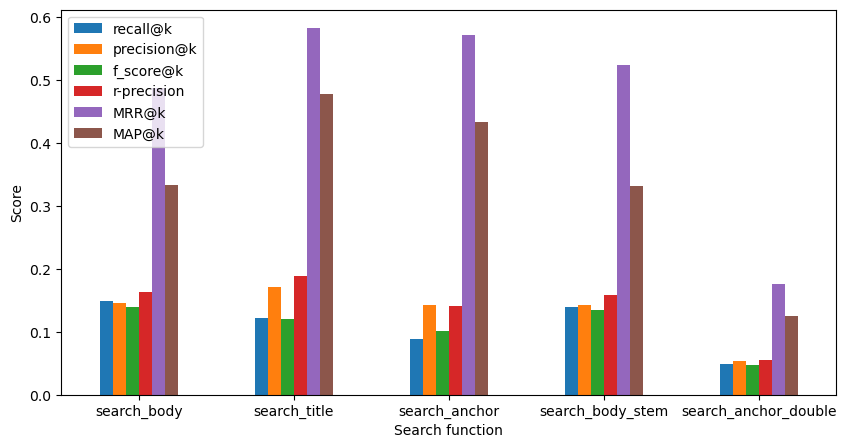

In [43]:

data = {'search_body': scores['search_body'][1], 'search_title': scores['search_title'][1], 'search_anchor': scores['search_anchor'][1],
        'search_body_stem': scores['search_body_stem'][1], 'search_anchor_double': scores['search_anchor_double'][1]}

# Create a dataframe from the data
df = pd.DataFrame(data)

# Transpose the dataframe
df = df.T

# Plot the dataframe
df.plot(kind='bar', rot=0, figsize=(10, 5))

plt.xlabel('Search function')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.show()

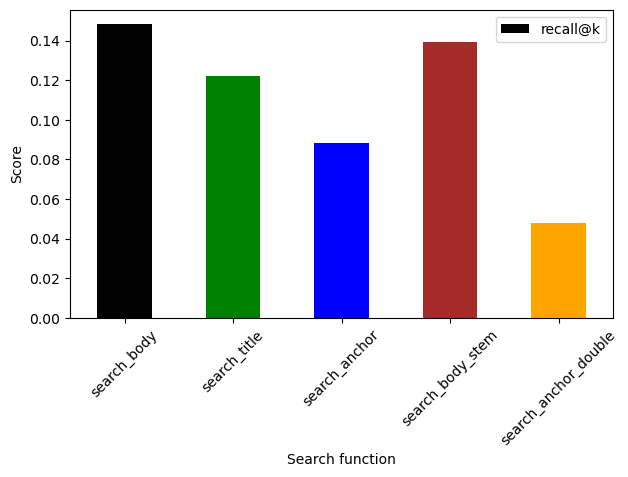

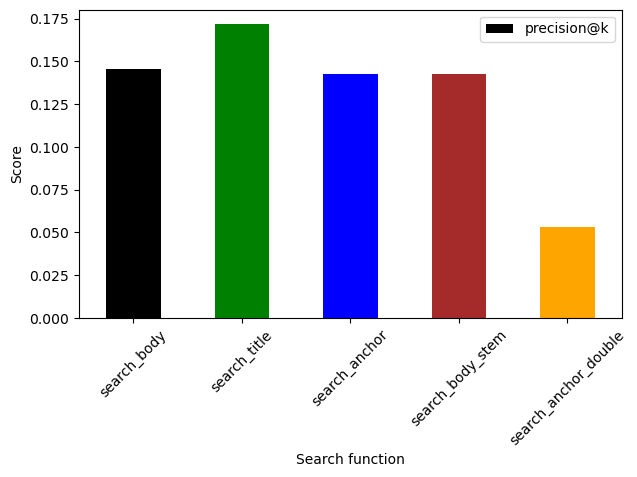

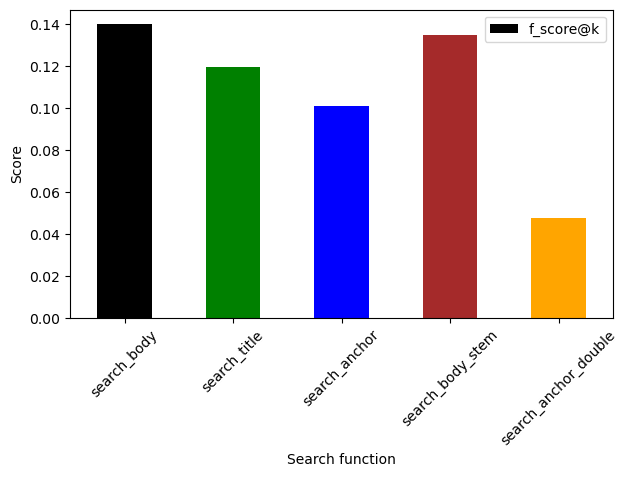

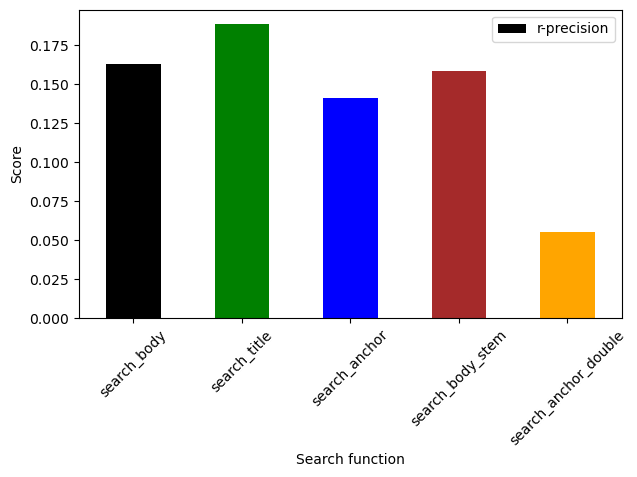

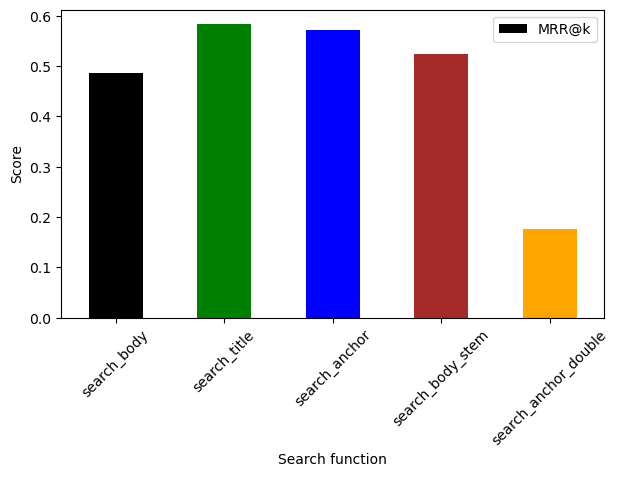

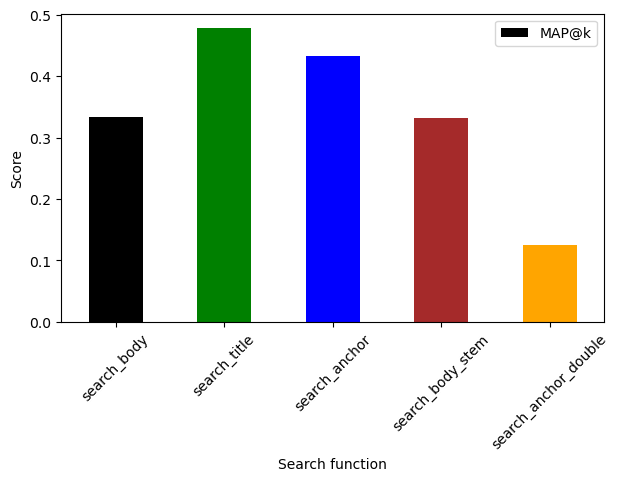

In [44]:
metrices_names = scores['search_body'][1].keys()
bar_colors = ['black', 'g', 'b', 'brown', 'orange']
for metric in metrices_names:
    # Extract the first metric
    metric_data = df[metric]

    # Plot the data
    metric_data.plot(kind='bar', rot=45, figsize=(7, 4), color=bar_colors)

    plt.xlabel('Search function')
    plt.ylabel('Score')
    plt.legend([metric])
    plt.show()

We can see that search body, anchor and title produce the best results among all search function by all metrices.

We will try to build a search function that use all of them to get best results.

Lets build 3 different search functions and compare their resuls.

In [45]:
# search using the search function from all the search functions ordered by page rank values
def search_v1(query):
    scores_by_page_rank = []
    doc_ids_title = calc_search_title(query)
    doc_ids_body = calc_search_body(query)
    doc_ids_anchor = calc_search_anchor(query)
    mutual_docs_ids = set(doc_ids_title) | set(doc_ids_body) |set(doc_ids_anchor)
    mutual_docs_ids = list(mutual_docs_ids)
    for doc_id in mutual_docs_ids:
        try:
            scores_by_page_rank.append((doc_id, page_rank[doc_id]))
        except:
            scores_by_page_rank.append((doc_id, 0))
    sorted_scores_by_page_rank = sorted(scores_by_page_rank, key=lambda x: x[1], reverse=True)
    return map_tuple2doc_id(sorted_scores_by_page_rank)


# search using the search function from all the search functions ordered by page views values
def search_v2(query):
    scores_by_page_views = []
    doc_ids_title = calc_search_title(query)
    doc_ids_body = calc_search_body(query)
    doc_ids_anchor = calc_search_anchor(query)
    mutual_docs_ids = set(doc_ids_title) | set(doc_ids_body) |set(doc_ids_anchor)
    mutual_docs_ids = list(mutual_docs_ids)
    for doc_id in mutual_docs_ids:
        scores_by_page_views.append((doc_id, page_views[doc_id]))
    sorted_scores_by_page_views = sorted(scores_by_page_views, key=lambda x: x[1], reverse=True)
    return map_tuple2doc_id(sorted_scores_by_page_views)


# search only by anchor index with word2vec model to extend query tokens.
def search_v3(query):
    query = tokenize(query, expand=True)
    docs_id = binary_search(query, anchor_index, ANCHOR_BUCKET)
    return docs_id[:100]


# search only by title index with word2vec model to extend query tokens.
def search_v4(query):
    query = tokenize(query, expand=True)
    docs_id = binary_search(query, title_index, TITLE_BUCKET)
    return docs_id[:100]


# search only by title index as it recieves the best results
def search_v5(query):
    return calc_search_title(query)

In [46]:
functions = [search_v1, search_v2, search_v3, search_v4, search_v5]
function_names = ["search v1", "search v2", "search v3", "search v4", "search v5"]
func_results = {}
for func, func_name in zip(functions, function_names):
    print(f"Scores for func {func_name}")
    func_results[func_name]= test_search_funcs_average_precision(func, queries)

Scores for func search v1
mean score: 0.21276666666666666
mean times: 2.6434393644332888
total time: 79.30318093299866
ansewr per each q: [('best marvel movie', 5.252385377883911, 0.0), ('How do kids come to world?', 8.185102224349976, 0.0), ('Information retrieval', 2.0452451705932617, 0.072), ('LinkedIn', 0.23394036293029785, 0.0), ('How to make coffee?', 0.34951066970825195, 0.111), ('Ritalin', 0.2274632453918457, 0.471), ('How to make wine at home?', 4.141626358032227, 0.0), ('Most expensive city in the world', 12.210655689239502, 0.0), ('India', 1.501166820526123, 0.654), ('how to make money fast?', 1.8174161911010742, 0.0), ('Netflix', 0.2907421588897705, 0.0), ('Apple computer', 1.3409299850463867, 0.0), ('The Simpsons', 0.3384573459625244, 0.111), ('World cup', 8.067598581314087, 0.13), ('How to lose weight?', 1.0568671226501465, 0.212), ('Java', 0.3774588108062744, 0.332), ('Air Jordan', 2.703242778778076, 0.0), ('how to deal with depression?', 1.5634174346923828, 0.157), ('Ho

In [47]:
func_results

{'search v1': (0.21276666666666666, 2.6434393644332888),
 'search v2': (0.26356666666666667, 2.5607208490371702),
 'search v3': (0.4325666666666666, 0.40377191702524823),
 'search v4': (0.4778333333333334, 0.22288017272949218),
 'search v5': (0.4778333333333334, 0.09385934670766195)}

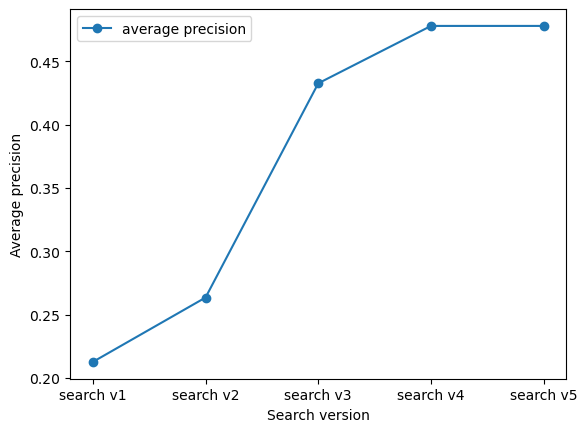

In [48]:
# Extract the x and y values for average precision and average time
x = list(func_results.keys())
y1 = [v[0] for v in func_results.values()]
y2 = [v[1] for v in func_results.values()]

# Create the Average precision plot
plt.plot(x, y1, '-o', label='average precision')
plt.xlabel('Search version')
plt.ylabel('Average precision')
plt.legend()
plt.show()

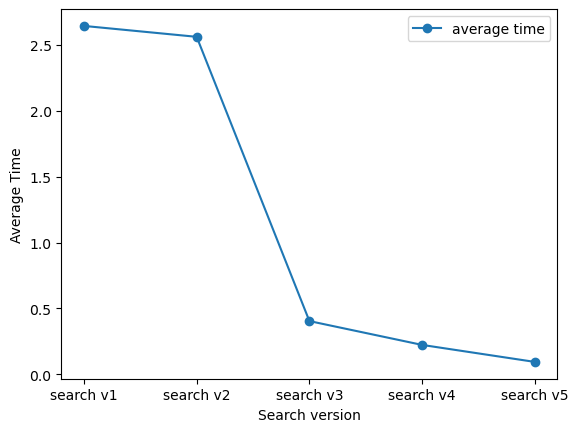

In [49]:
# Create the Average Time plot
plt.plot(x, y2, '-o', label='average time')
plt.xlabel('Search version')
plt.ylabel('Average Time')
plt.legend()
plt.show()

In [50]:
scores ={}
for func, func_name in zip(functions, function_names):
    print(f"Scores for func {func_name}")
    scores[func_name] = test_search_funcs_all_metrices(func, queries)

Scores for func search v1
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.11396666666666665, 'precision@k': 0.12249999999999998, 'f_score@k': 0.10670365299948108, 'r-precision': 0.11673333333333333, 'MRR@k': 0.27535510785510786, 'MAP@k': 0.21276666666666666})
Scores for func search v2
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.11396666666666665, 'precision@k': 0.17083333333333334, 'f_score@k': 0.12317937371163214, 'r-precision': 0.16823333333333332, 'MRR@k': 0.3726165092217724, 'MAP@k': 0.26356666666666667})
Scores for func search v3
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.08829999999999999, 'precision@k': 0.14250000000000002, 'f_score@k': 0.10105345657366055, 'r-precision': 0.14116666666666663, 'MRR@k': 0.5712830687830687, 'MAP@k': 0.4325666666666666})
Scores for func search v4
Average scores over all queries: defaultdict(<class 'float'>, {'recall@k': 0.12206666666666664, 'precision@k':

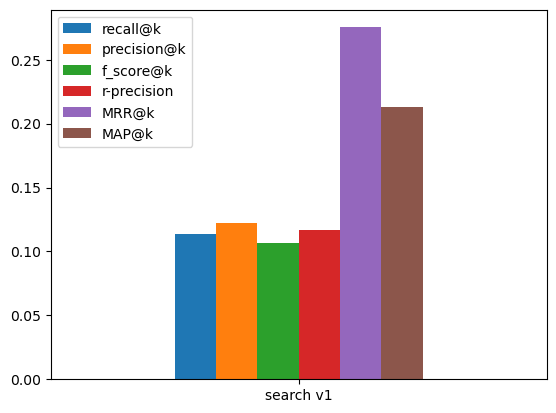

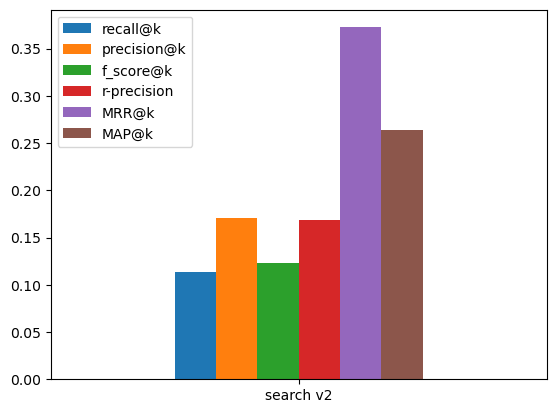

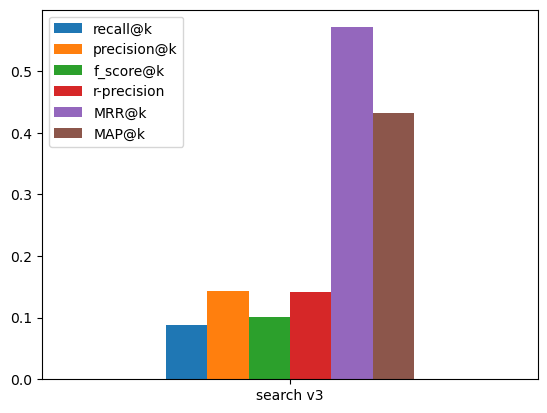

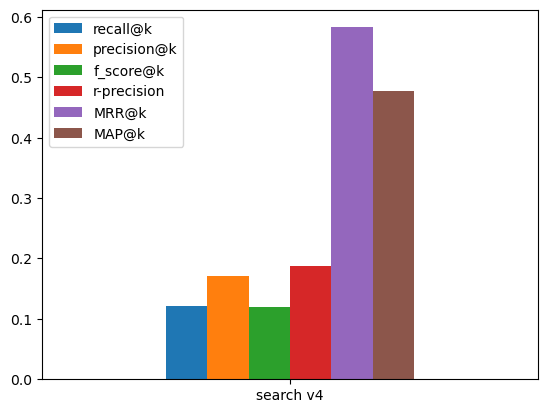

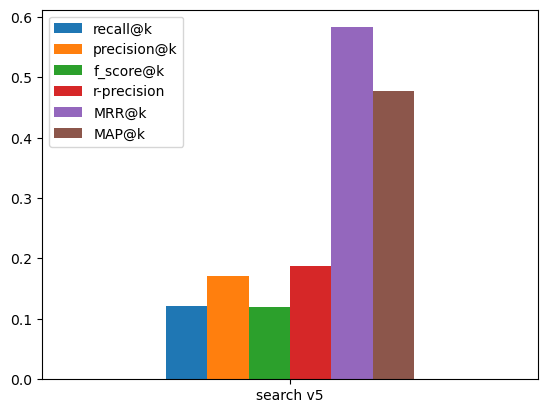

In [51]:
for func_name, func_scores in scores.items():
    pd.DataFrame(func_scores[1], index=[func_name]).plot(kind='bar', rot=0)

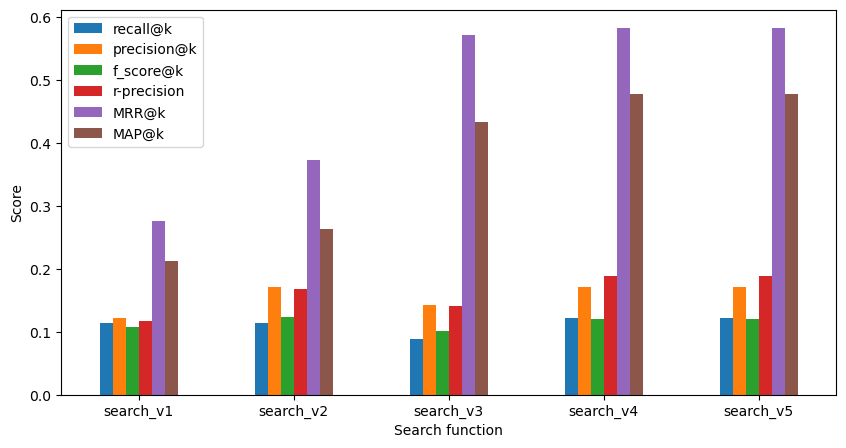

In [52]:
data = {'search_v1': scores['search v1'][1], 'search_v2': scores['search v2'][1], 'search_v3': scores['search v3'][1],
        'search_v4': scores['search v4'][1], 'search_v5': scores['search v5'][1]}

# Create a dataframe from the data
df = pd.DataFrame(data)

# Transpose the dataframe
df = df.T

# Plot the dataframe
df.plot(kind='bar', rot=0, figsize=(10, 5))

plt.xlabel('Search function')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.show()

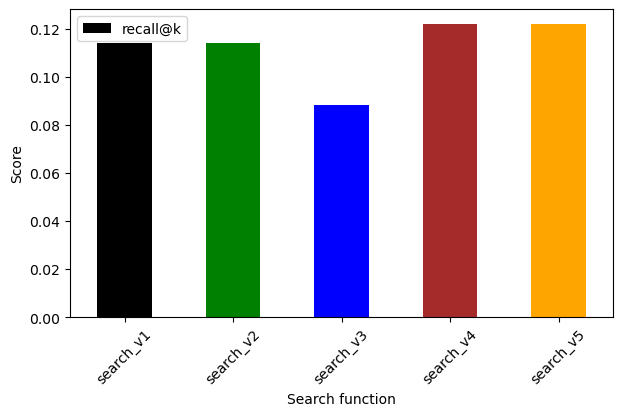

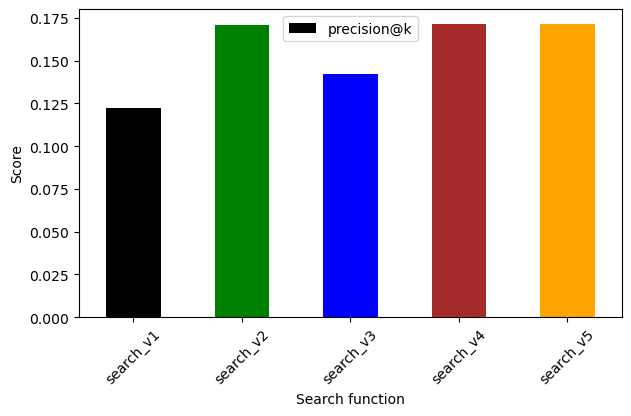

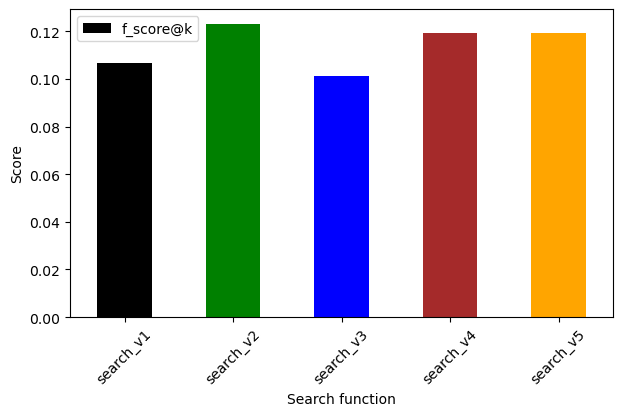

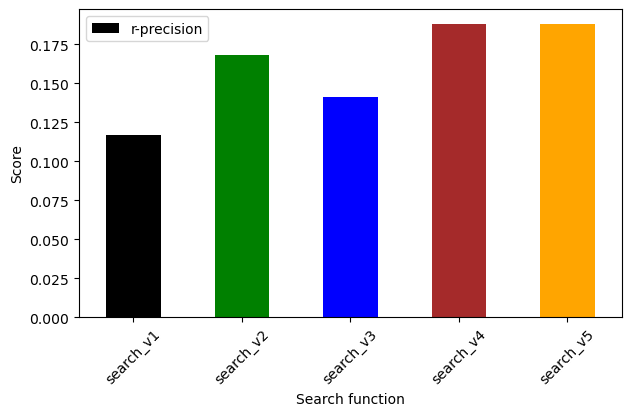

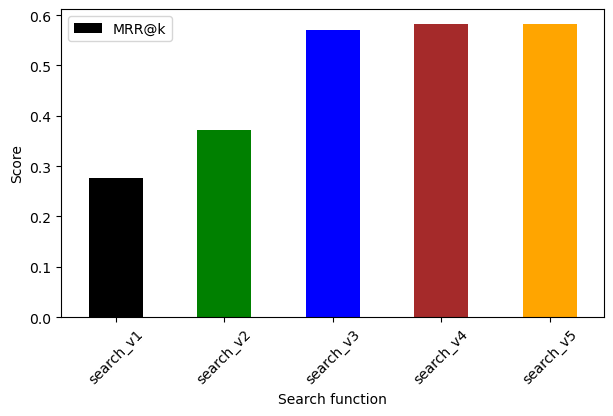

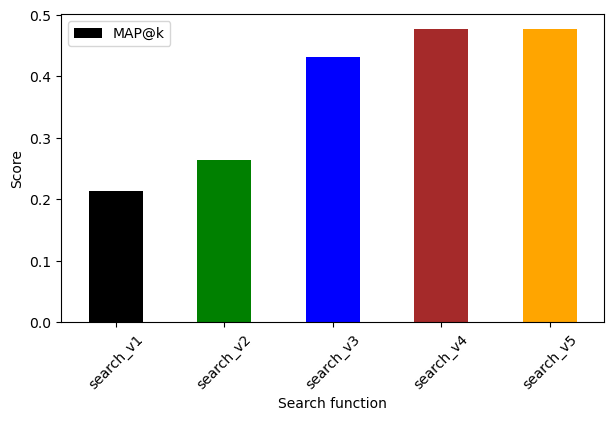

In [53]:
metrices_names = scores['search v1'][1].keys()
bar_colors = ['black', 'g', 'b', 'brown', 'orange']
for metric in metrices_names:
    # Extract the first metric
    metric_data = df[metric]

    # Plot the data
    metric_data.plot(kind='bar', rot=45, figsize=(7, 4), color=bar_colors)

    plt.xlabel('Search function')
    plt.ylabel('Score')
    plt.legend([metric])
    plt.show()

We can see that search version 5 has the best results among the metrices compared, therfore we choose this search function to be the main search function.